## Notebook example of Diviner's GroupedPmdarima API

This notebook shows a comparison of 4 primary means of utilizing the GroupedPmdarima API in Diviner:
- Standard ARIMA
  - A user-supplied manual configuration of ARIMA models to be built based on the configured order terms. This approach is useful for hierarchical multi-series optimization techniques (where ordering terms are determined by evaluating the optimal parameters from a higher level aggregation of disparate series that share a similar seasonality with one another). 
  - Note that this is the fastest execution available and is recommended to be used if there is homogeny amongst a large collection of individual series (i.e., forecasting SKU scales at 500 different stores would use a global SKU forecasting model through AutoARIMA to determine the optimal ordering terms, then apply those to each individual store's ARIMA models through this mode).
- AutoARIMA
  - An automate approach that will perform a best-effort optimization of ordering terms.
- Seasonal AutoARIMA
  - A much slower, but, depending on the nature of the series data, potentially much more accurate model for each series. 
- Pipeline preprocessing + AutoARIMA
  - This mode applies a data transformer (exogeneous transformers are currently not supported) such as a LogEndogTransformer or BoxCoxEndogTransformer. Depending on the nature of the data, this may dramatically improve the forecasting quality.

In [2]:
import itertools
import pandas as pd
import numpy as np
import string
import random
from datetime import timedelta, datetime
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.cm as cmx

from pmdarima.arima.arima import ARIMA
from pmdarima.arima.auto import AutoARIMA
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima.model_selection import SlidingWindowForecastCV
from diviner import GroupedPmdarima, PmdarimaAnalyzer

In [3]:
def _build_trend(size):
    raw_trend = (
        np.arange(size) * np.random.uniform(-0.05, 0.2)
    ) + np.random.randint(200, 500)
    return raw_trend


def _build_seasonality(size, period):
    repeated_x = np.arange(period) + 3

    raw_values = np.where(repeated_x < 5, repeated_x**4, 
                          np.where(repeated_x < 7, repeated_x**3, 
                                   repeated_x**2)
                         )
    
    seasonality = raw_values 
    for i in range(int(size / period) - 1):
        seasonality = np.append(seasonality, raw_values)
    return seasonality * np.random.randint(1, 4)


def _build_residuals(size):
    return np.random.randn(size) * np.random.randint(4, 10)


def _generate_time_series(size, seasonal_period):
    return (
        _build_trend(size)
        + _build_seasonality(size, seasonal_period)
        + _build_residuals(size)
    )


def _generate_grouping_columns(column_count: int, series_count: int):
    candidate_list = list(string.ascii_uppercase)
    candidates = random.sample(
        list(itertools.permutations(candidate_list, column_count)), series_count
    )
    column_names = sorted([f"key{x}" for x in range(column_count)], reverse=True)
    return [dict(zip(column_names, entries)) for entries in candidates]


def _generate_raw_df(
    column_count: int,
    series_count: int,
    series_size: int,
    series_seasonal_period: int,
    start_dt: str,
    days_period: int,
):
    candidates = _generate_grouping_columns(column_count, series_count)
    start_date = datetime.strptime(start_dt, "%Y-%M-%d")
    dates = np.arange(
        start_date,
        start_date + timedelta(days=series_size * days_period),
        timedelta(days=days_period),
    )
    df_collection = []
    for entry in candidates:
        generated_series = _generate_time_series(series_size, series_seasonal_period)
        series_dict = {"ds": dates, "y": generated_series}
        series_df = pd.DataFrame.from_dict(series_dict)
        for column, value in entry.items():
            series_df[column] = value
        df_collection.append(series_df)
    return pd.concat(df_collection)


def generate_example_data(
    column_count: int,
    series_count: int,
    series_size: int,
    series_seasonal_period: int,
    start_dt: str,
    days_period: int = 1,
):

    Structure = namedtuple("Structure", "df key_columns")
    data = _generate_raw_df(
        column_count, series_count, series_size, series_seasonal_period, start_dt, days_period
    )
    key_columns = list(data.columns)

    for key in ["ds", "y"]:
        key_columns.remove(key)

    return Structure(data, key_columns)

def plot_grouped_series(df, key_columns, time_col, y_col):
    grouped = df.groupby(key_columns)
    ncols = 1
    nrows = int(np.ceil(grouped.ngroups/ncols))
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=(16, 6*grouped.ngroups), 
                             sharey=False, 
                             sharex=False
                            )
    cmap = [cmx.Dark2(x) for x in np.linspace(0.0, 1.0, grouped.ngroups)]
    i=0
    for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
        ser = grouped.get_group(key)
        rgb = cmap[i]
        ax.plot(ser[time_col], ser[y_col], label="y value", c=rgb)
        ax.legend()
        ax.title.set_text(f"Group: {key}")
        i+=1
    plt.show()

def plot_grouped_series_forecast(df, key_columns, time_col, y_col, yhat_lower_col, yhat_upper_col):
    
    grouped = df.groupby(key_columns)
    ncols = 1
    nrows = int(np.ceil(grouped.ngroups/ncols))
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=(16, 8*grouped.ngroups), 
                             sharey=False, 
                             sharex=False
                            )
    cmap = [cmx.Dark2(x) for x in np.linspace(0.0, 1.0, grouped.ngroups)]
    i=0
    for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
        ser = grouped.get_group(key)
        rgb = cmap[i]
        ax.plot(ser[time_col], ser[y_col], label="y value", c=rgb)
        ax.fill_between(ser[time_col], 
                        ser[yhat_lower_col], 
                        ser[yhat_upper_col], 
                        color=rgb, 
                        alpha=0.3,
                        label="error"
                       )
        ax.legend(loc="upper left")
        ax.title.set_text(f"Group: {key}")
        ax.grid(color=rgb, linewidth=0.5, alpha=0.5)
        i+=1
    plt.show()

In [4]:
data = generate_example_data(3, 5, 1050, 7, "2017-01-01", 1)

### View the synthetic generated data

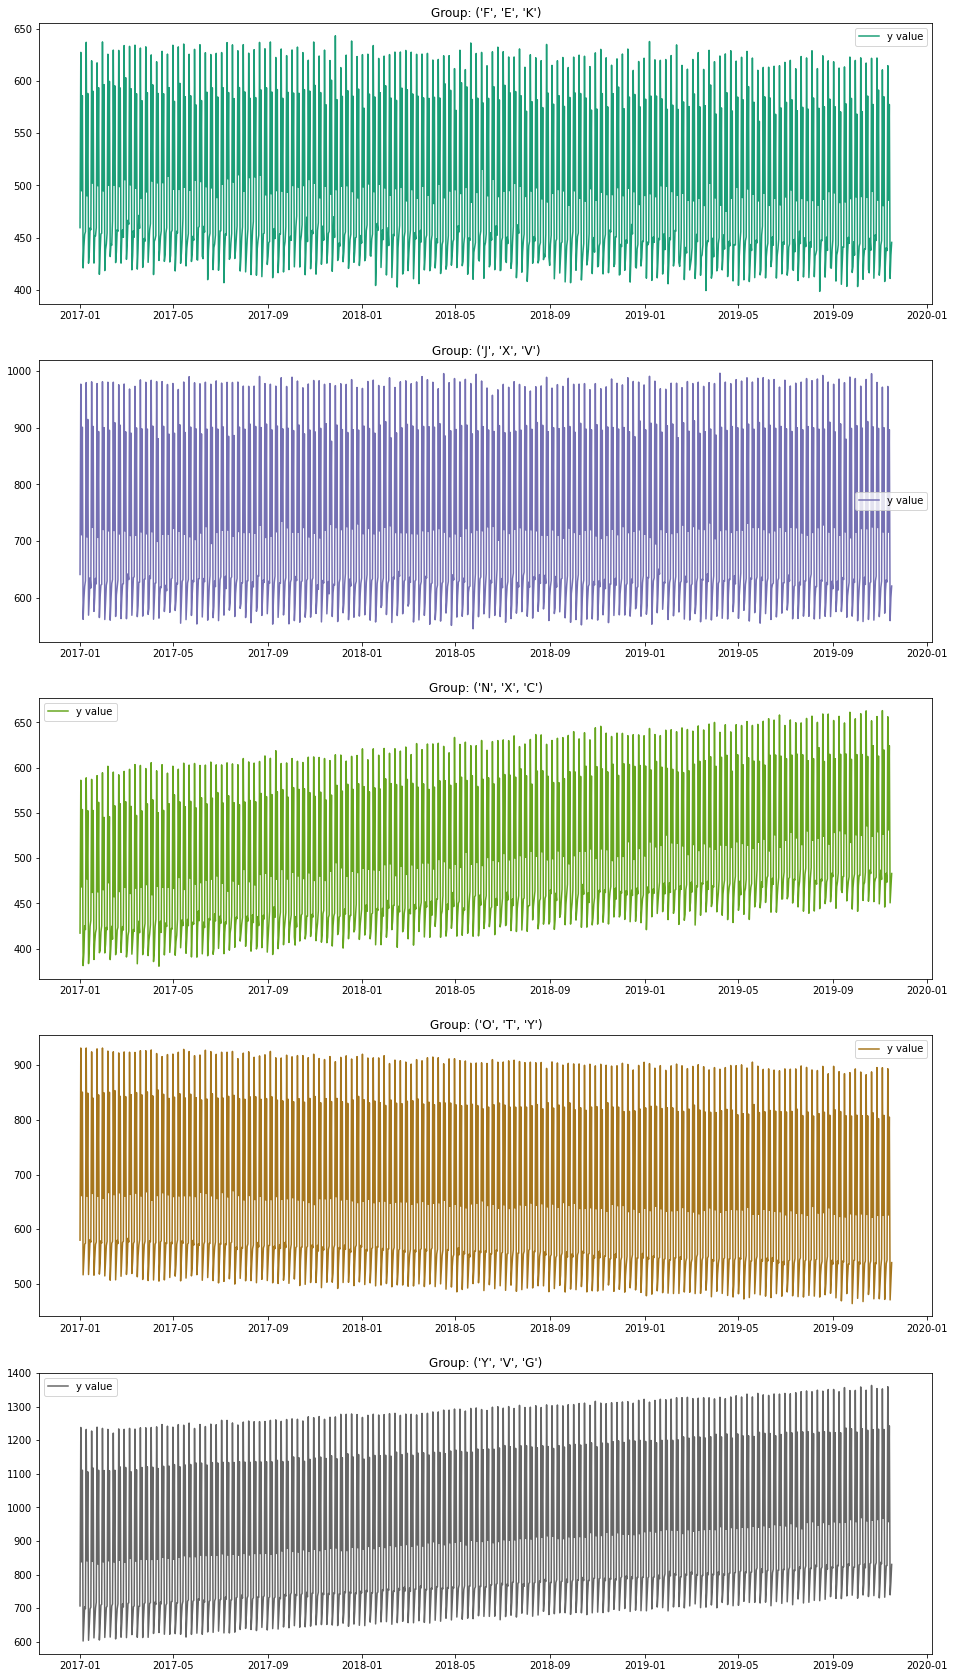

In [5]:
plot_grouped_series(data.df, data.key_columns, "ds", "y")

## ARIMA manually defined ordering terms

In [6]:
data_utils = PmdarimaAnalyzer(data.df, data.key_columns, "y", "ds")

ndiffs = data_utils.calculate_ndiffs(alpha=0.05, test="kpss", max_d=7)
ndiffs

{('F', 'E', 'K'): 1,
 ('J', 'X', 'V'): 0,
 ('N', 'X', 'C'): 1,
 ('O', 'T', 'Y'): 1,
 ('Y', 'V', 'G'): 1}

The results above for the ndiffs method shows that each group's differencing value should be set to '1'. This isn't surprising based on how the generated data was created. Real world data sets may have different optimal 'd' values, though. Performing a manual validation can dramatically reduce optimization time for the AutoARIMA methods (which will be covered further down in this example notebook).

#### Let's check the seasonal differencing as well.

In [7]:
nsdiffs = data_utils.calculate_nsdiffs(m=20, test="ocsb", max_D=30)
nsdiffs

{('F', 'E', 'K'): 0,
 ('J', 'X', 'V'): 0,
 ('N', 'X', 'C'): 0,
 ('O', 'T', 'Y'): 0,
 ('Y', 'V', 'G'): 0}

#### Calculate the acf values for each group to aid in setting the ARIMA 'p' parameter.

In [8]:
acf = data_utils.calculate_acf(alpha=0.05, qstat=True)
acf

{('F',
  'E',
  'K'): {'acf': array([ 1.        , -0.08070348,  0.17113533, -0.57432053, -0.57269233,
          0.16892029, -0.08007331,  0.9866866 , -0.08029439,  0.16979978,
         -0.57130432, -0.56881352,  0.16684712, -0.07890206,  0.98009748,
         -0.07907823,  0.16909447, -0.56757814, -0.56480278,  0.16576373,
         -0.07812178,  0.97376666, -0.07840144,  0.16723731, -0.56373238,
         -0.56227819,  0.1649875 , -0.07771043,  0.96709519, -0.07748238,
          0.16583409]), 'confidence_intervals': array([[ 1.00000000e+00,  1.00000000e+00],
         [-1.41189283e-01, -2.02176793e-02],
         [ 1.10256857e-01,  2.32013805e-01],
         [-6.36934311e-01, -5.11706747e-01],
         [-6.52278609e-01, -4.93106048e-01],
         [ 7.54654815e-02,  2.62375098e-01],
         [-1.74638559e-01,  1.44919437e-02],
         [ 8.91873617e-01,  1.08149958e+00],
         [-2.07231513e-01,  4.66427328e-02],
         [ 4.26769784e-02,  2.96922590e-01],
         [-6.99254204e-01, -4.43

#### And the partial autocorrelation function values...

In [9]:
pacf = data_utils.calculate_pacf(nlags=40, alpha=0.05)
pacf

{('F',
  'E',
  'K'): {'pacf': array([ 1.        , -0.08078041,  0.16601981, -0.57034304, -0.9620566 ,
          0.61323735,  0.04746202,  0.77862671,  0.00637416, -0.08100356,
         -0.05871874, -0.13700759,  0.1174423 ,  0.0605576 ,  0.42934315,
          0.09243144, -0.07328271,  0.00398806, -0.100308  ,  0.1303113 ,
          0.05355023,  0.31839881,  0.08861446, -0.22613491,  0.01178529,
         -0.22631973,  0.18613883,  0.15154231,  0.24202115,  0.14823025,
         -0.36025751, -0.00747563, -0.09967852,  0.27377749,  0.2899224 ,
          0.03164718, -0.01778687, -0.72500717,  0.08315487,  0.44580926,
          1.87065584]), 'confidence_intervals': array([[ 1.00000000e+00,  1.00000000e+00],
         [-1.41266216e-01, -2.02946130e-02],
         [ 1.05534006e-01,  2.26505610e-01],
         [-6.30828837e-01, -5.09857234e-01],
         [-1.02254240e+00, -9.01570796e-01],
         [ 5.52751546e-01,  6.73723149e-01],
         [-1.30237844e-02,  1.07947819e-01],
         [ 7.18140

#### Start with a simple ARIMA model with explicitly defined (p, d, q) values.
These values were determined by aggregating all of the series into a single representative series, run through AutoARIMA to determine the p, d, q order terms, and applied to each series individually. 

Note that this approach will not work if the series have different seasonality attributes (series 'a' has a weekly seasonality while series 'b' has a monthly seasonality), if the series has a complex seasonality (compounding weekly, day of month, and month of year effects), or if the any of the ordering terms (differencing, order, or moving average order) are significantly different for the different independent series.

In [11]:
arima_base = ARIMA(order=(4, 1, 5), out_of_sample_size=14)
group_arima = GroupedPmdarima(
    model_template=arima_base
)

#### Fit the grouped Pmdarima model

In [12]:
group_arima_model = group_arima.fit(df=data.df, 
                                    group_key_columns=data.key_columns, 
                                    y_col="y", 
                                    datetime_col="ds", 
                                    silence_warnings=True)

#### Let's see what the parameters were from the run.

In [13]:
group_arima_model.get_model_params()

,grouping_key_columns,key2,key1,key0,maxiter,method,out_of_sample_size,scoring,scoring_args,start_params,suppress_warnings,trend,with_intercept,p,d,q,P,D,Q,s
0,"(key2, key1, key0)",F,E,K,50,lbfgs,14,mse,None,None,False,None,True,4,1,5,0,0,0,0
1,"(key2, key1, key0)",J,X,V,50,lbfgs,14,mse,None,None,False,None,True,4,1,5,0,0,0,0
2,"(key2, key1, key0)",N,X,C,50,lbfgs,14,mse,None,None,False,None,True,4,1,5,0,0,0,0
3,"(key2, key1, key0)",O,T,Y,50,lbfgs,14,mse,None,None,False,None,True,4,1,5,0,0,0,0
4,"(key2, key1, key0)",Y,V,G,50,lbfgs,14,mse,None,None,False,None,True,4,1,5,0,0,0,0


#### Let's take a look at the training metrics

In [14]:
group_arima_model.get_metrics()

,grouping_key_columns,key2,key1,key0,hqic,aicc,oob,bic,aic
0,"(key2, key1, key0)",F,E,K,7308.479882,7288.064205,26.639746,7342.321388,7287.809869
1,"(key2, key1, key0)",J,X,V,8529.693560,8509.277883,73.661043,8563.535066,8509.023548
2,"(key2, key1, key0)",N,X,C,7094.464510,7074.048832,33.927776,7128.306016,7073.794497
3,"(key2, key1, key0)",O,T,Y,7636.027821,7615.612144,118.098407,7669.869327,7615.357809
4,"(key2, key1, key0)",Y,V,G,8408.200891,8387.785213,177.272914,8442.042397,8387.530878


The out of bounds measure on the 14 day validation period doesn't look too bad. Let's save this model.

#### Save it to a local directory

In [15]:
group_arima_model.save("./group_arima.gpmd")

#### Load the saved model and perform a forecast for each group.

In [16]:
loaded_arima = GroupedPmdarima.load("./group_arima.gpmd")

In [17]:
forecast = loaded_arima.predict(n_periods = 60, alpha=0.5, predict_col="forecast", return_conf_int=True)
forecast

,grouping_key_columns,key2,key1,key0,forecast,yhat_lower,yhat_upper,ds
0,"(key2, key1, key0)",F,E,K,439.455456,433.443671,445.467241,2019-11-17 00:01:00
1,"(key2, key1, key0)",F,E,K,611.627138,605.596691,617.657586,2019-11-18 00:01:00
2,"(key2, key1, key0)",F,E,K,485.765766,479.734559,491.796972,2019-11-19 00:01:00
3,"(key2, key1, key0)",F,E,K,581.559916,575.493820,587.626011,2019-11-20 00:01:00
4,"(key2, key1, key0)",F,E,K,410.152148,403.979627,416.324670,2019-11-21 00:01:00
...,...,...,...,...,...,...,...,...
295,"(key2, key1, key0)",Y,V,G,868.854019,849.593089,888.114949,2020-01-11 00:01:00
296,"(key2, key1, key0)",Y,V,G,844.56244,825.194837,863.930042,2020-01-12 00:01:00
297,"(key2, key1, key0)",Y,V,G,1336.358013,1316.951209,1355.764817,2020-01-13 00:01:00
298,"(key2, key1, key0)",Y,V,G,961.353673,941.932352,980.774994,2020-01-14 00:01:00


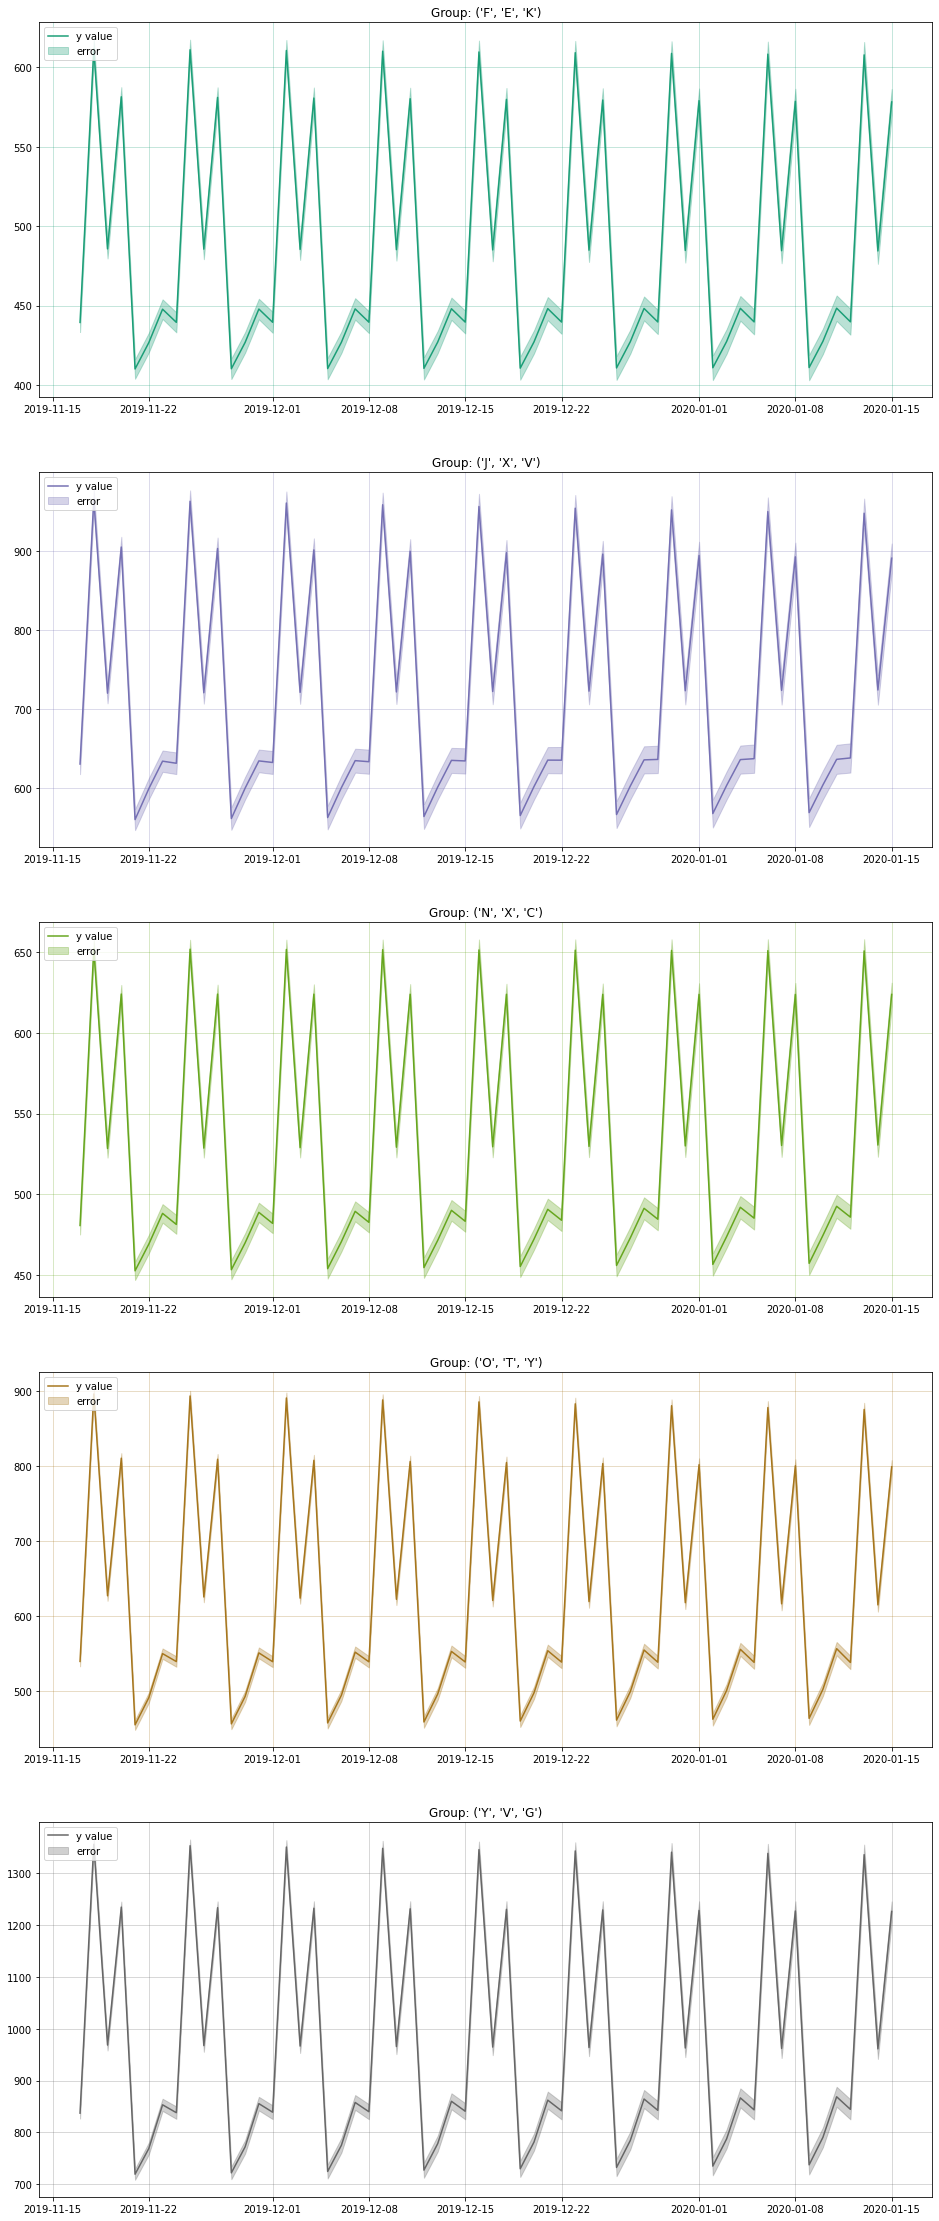

In [18]:
plot_grouped_series_forecast(forecast, data.key_columns, "ds", "forecast", "yhat_lower", "yhat_upper")

The ordering terms that were used above, ``(4, 1, 5)`` were determined via using AutoARIMA against the average of all generated series. This approach, a hierarchal optimization of multi series data, is very effective and should be pursued first if at all possible.

## AutoARIMA with seasonality components
Since we know that these data sets have a weekly periodicity and that they're generated on a daily basis, let's set m=7. This will apply a seasonality term to the ARIMA model (making it a SARIMA model) and opening up the tuning of the seasonal components (P, D, Q). 

Note: This will take **much longer to run**.

In [19]:
auto_arima = AutoARIMA(out_of_sample_size=14, 
                       maxiter=500, 
                       max_order=7,
                       d=1,
                       m=7
                      )
auto_arima_model = GroupedPmdarima(model_template=auto_arima).fit(
    df=data.df, 
    group_key_columns=data.key_columns, 
    y_col="y", 
    datetime_col="ds", 
    silence_warnings=True)

#### Let's see what the parameters are for this run.

In [20]:
auto_arima_model.get_model_params()

,grouping_key_columns,key2,key1,key0,maxiter,method,out_of_sample_size,scoring,scoring_args,start_params,suppress_warnings,trend,with_intercept,p,d,q,P,D,Q,s
0,"(key2, key1, key0)",F,E,K,500,lbfgs,14,mse,{},None,True,None,False,5,1,0,2,1,0,7
1,"(key2, key1, key0)",J,X,V,500,lbfgs,14,mse,{},None,True,None,False,5,1,0,2,1,0,7
2,"(key2, key1, key0)",N,X,C,500,lbfgs,14,mse,{},None,True,None,False,5,1,0,2,1,0,7
3,"(key2, key1, key0)",O,T,Y,500,lbfgs,14,mse,{},None,True,None,False,5,1,0,2,1,0,7
4,"(key2, key1, key0)",Y,V,G,500,lbfgs,14,mse,{},None,True,None,False,5,1,0,2,1,0,7


#### And the training metrics...

In [21]:
auto_arima_model.get_metrics()

,grouping_key_columns,key2,key1,key0,hqic,aicc,oob,bic,aic
0,"(key2, key1, key0)",F,E,K,7238.444457,7223.565458,36.179148,7263.018307,7223.427129
1,"(key2, key1, key0)",J,X,V,7500.385256,7485.506257,104.947817,7524.959107,7485.367929
2,"(key2, key1, key0)",N,X,C,6831.858389,6816.979390,18.105916,6856.432240,6816.841062
3,"(key2, key1, key0)",O,T,Y,6355.091450,6340.212451,43.374184,6379.665300,6340.074122
4,"(key2, key1, key0)",Y,V,G,6320.132335,6305.253336,23.108154,6344.706185,6305.115008


#### And check the cross validation of each group's model to see what our error metrics are for prediction via backtesting.

In [22]:
auto_arima_forecast = auto_arima_model.predict(n_periods = 60, alpha=0.05, return_conf_int=True)

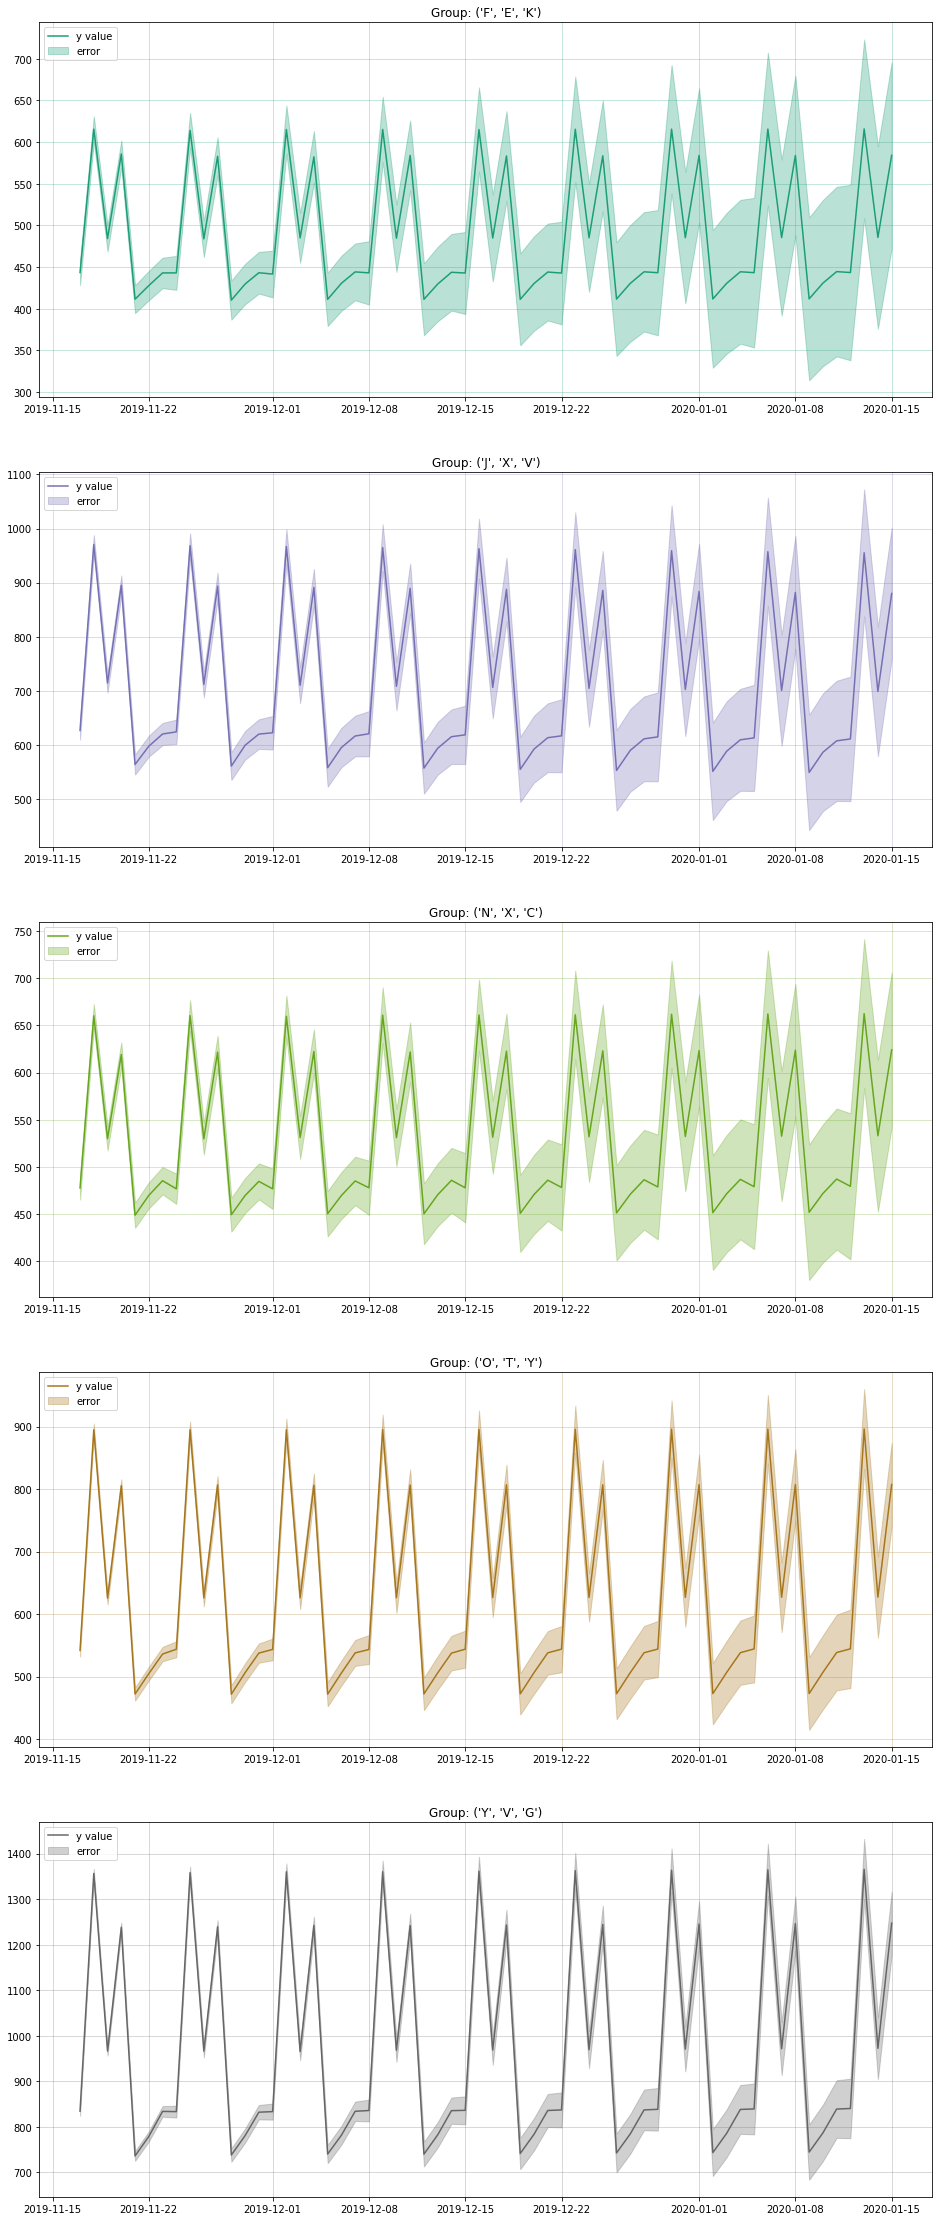

In [23]:
plot_grouped_series_forecast(auto_arima_forecast, data.key_columns, "ds", "yhat", "yhat_lower", "yhat_upper")

The seasonal components for this example aren't quite as great as the first example. However, this is due to the nature of this generated synthetic example data. For many real-world complex series data, using a seasonal approach with each model getting fit with its own optimal AR terms (p, d, q) and seasonal terms (P, D, Q) can provide better results than manually specifying them. 

#### Cross validation backtesting on the models to get the error metrics

In [24]:
auto_arima_cv_window = SlidingWindowForecastCV(h=28, step=180, window_size=365)

auto_arima_cv = auto_arima_model.cross_validate(df=data.df, 
                                                metrics=["mean_squared_error", "smape", "mean_absolute_error"],
                                                cross_validator=auto_arima_cv_window,
                                                error_score=np.nan,
                                                verbosity=4
                                               )

[CV] fold=0 ..........................................................
fold=0, score=79.808 [time=27.476 sec]
[CV] fold=1 ..........................................................
fold=1, score=59.472 [time=41.604 sec]
[CV] fold=2 ..........................................................
fold=2, score=232.314 [time=25.329 sec]
[CV] fold=3 ..........................................................
fold=3, score=49.415 [time=21.327 sec]
[CV] fold=0 ..........................................................
fold=0, score=1.542 [time=26.895 sec]
[CV] fold=1 ..........................................................
fold=1, score=1.240 [time=40.395 sec]
[CV] fold=2 ..........................................................
fold=2, score=2.711 [time=25.616 sec]
[CV] fold=3 ..........................................................
fold=3, score=1.138 [time=21.324 sec]
[CV] fold=0 ..........................................................
fold=0, score=7.313 [time=26.776 sec]
[CV] fold=1 ..

In [25]:
auto_arima_cv

,grouping_key_columns,key2,key1,key0,mean_squared_error_mean,mean_squared_error_stddev,smape_mean,smape_stddev,mean_absolute_error_mean,mean_absolute_error_stddev
0,"(key2, key1, key0)",F,E,K,105.252090,74.171681,1.657663,0.626170,8.007901,3.036208
1,"(key2, key1, key0)",J,X,V,106.700806,26.631834,1.181143,0.148013,8.119500,1.052836
2,"(key2, key1, key0)",N,X,C,32.220902,1.110630,0.942818,0.053464,4.625816,0.161250
3,"(key2, key1, key0)",O,T,Y,31.694749,6.090290,0.760451,0.076121,4.615029,0.381769
4,"(key2, key1, key0)",Y,V,G,40.261072,38.594749,0.570198,0.296271,4.887450,2.479422


### AutoARIMA without seasonality components

In [26]:
auto_arima_no_seasonal = AutoARIMA(out_of_sample_size=14, maxiter=500, d=1, max_order=14) # leaving the 'm' arg out.

auto_arima_no_seasonal_obj = GroupedPmdarima(model_template=auto_arima_no_seasonal)

auto_arima_model_no_seasonal = auto_arima_no_seasonal_obj.fit(df=data.df, 
                                                              group_key_columns=data.key_columns, 
                                                              y_col="y", 
                                                              datetime_col="ds", 
                                                              silence_warnings=True
                                                             )

In [27]:
auto_arima_model_no_seasonal.get_model_params()

,grouping_key_columns,key2,key1,key0,maxiter,method,out_of_sample_size,scoring,scoring_args,start_params,suppress_warnings,trend,with_intercept,p,d,q,P,D,Q,s
0,"(key2, key1, key0)",F,E,K,500,lbfgs,14,mse,{},None,True,None,False,2,1,2,0,0,0,0
1,"(key2, key1, key0)",J,X,V,500,lbfgs,14,mse,{},None,True,None,False,2,1,0,0,0,0,0
2,"(key2, key1, key0)",N,X,C,500,lbfgs,14,mse,{},None,True,None,True,4,1,3,0,0,0,0
3,"(key2, key1, key0)",O,T,Y,500,lbfgs,14,mse,{},None,True,None,False,4,1,5,0,0,0,0
4,"(key2, key1, key0)",Y,V,G,500,lbfgs,14,mse,{},None,True,None,False,5,1,4,0,0,0,0


In [28]:
auto_arima_model_no_seasonal.get_metrics()

,grouping_key_columns,key2,key1,key0,hqic,aicc,oob,bic,aic
0,"(key2, key1, key0)",F,E,K,11803.021777,11793.683788,4803.128966,11818.404280,11793.626317
1,"(key2, key1, key0)",J,X,V,13775.437281,13769.822949,32134.899126,13784.666782,13769.800005
2,"(key2, key1, key0)",N,X,C,7591.362347,7574.623595,85.834726,7619.050852,7574.450519
3,"(key2, key1, key0)",O,T,Y,7181.798445,7163.219266,51.496175,7212.563450,7163.007524
4,"(key2, key1, key0)",Y,V,G,8291.866077,8273.286898,108.699561,8322.631082,8273.075156


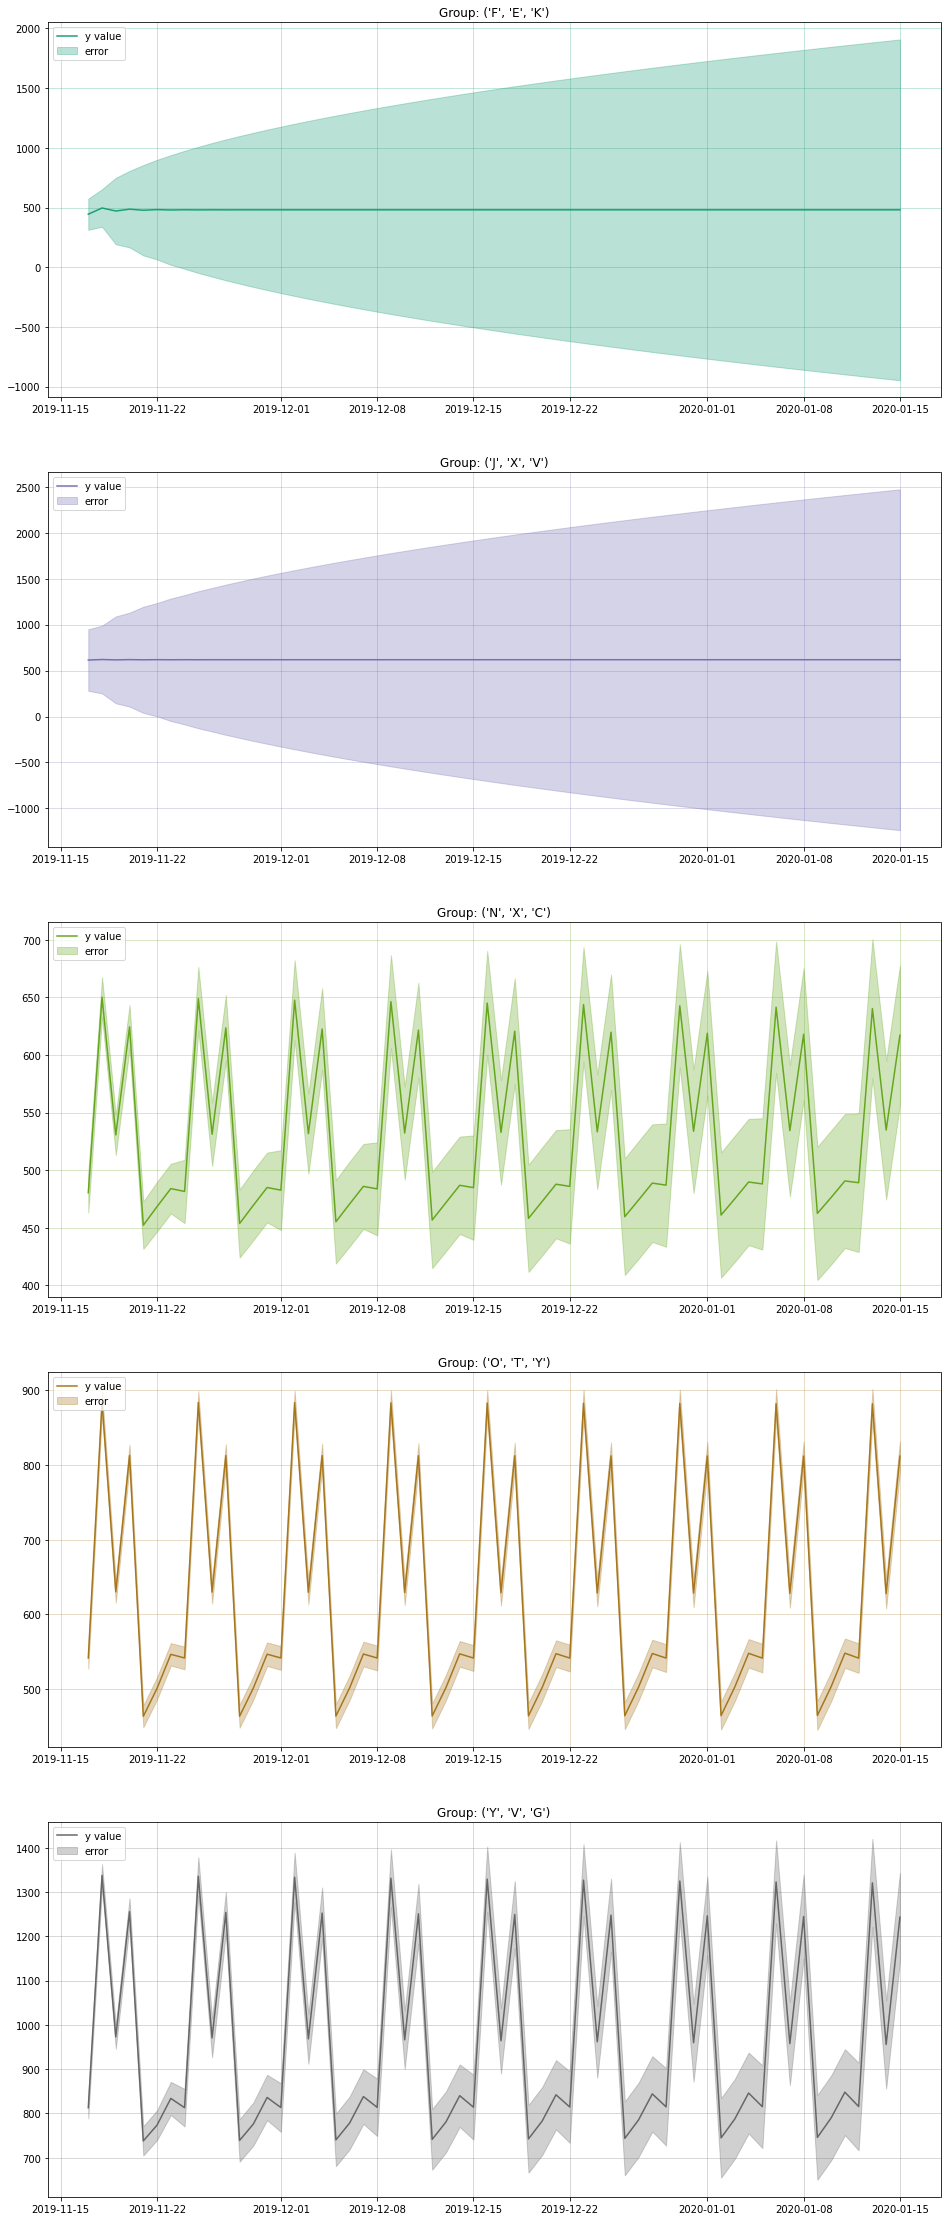

In [29]:
auto_arima_forecast_no_seasonal = auto_arima_model_no_seasonal.predict(n_periods = 60, 
                                                                       alpha=0.05, 
                                                                       return_conf_int=True
                                                                      )
plot_grouped_series_forecast(auto_arima_forecast_no_seasonal, 
                             data.key_columns, 
                             "ds", 
                             "yhat", 
                             "yhat_lower", 
                             "yhat_upper"
                            )

These are the results when allowing AutoARIMA to optimize without specifying the seasonal 'm' value. They're definitely not as great since the generated data has a clear weekly seasonality component and the optimizer will struggle to find appropriate ordering terms for this type of data.

## Pipeline orchestration with data preprocessing

In [78]:
pipeline_obj = Pipeline(
    steps=[
        (
            "log",
            LogEndogTransformer(lmbda=0.2, neg_action="raise", floor=1e-12),
        ),
        ("arima", AutoARIMA(out_of_sample_size=14, max_order=14, d=1, suppress_warnings=True)),
    ]
)

pipeline_arima = GroupedPmdarima(
    y_col="y", datetime_col="ds", model_template=pipeline_obj
).fit(df=data.df, group_key_columns=data.key_columns, silence_warnings=True)

In [79]:
pipeline_forecast = pipeline_arima.predict(n_periods = 60, 
                                                         alpha=0.05, 
                                                         return_conf_int=True
                                                        )

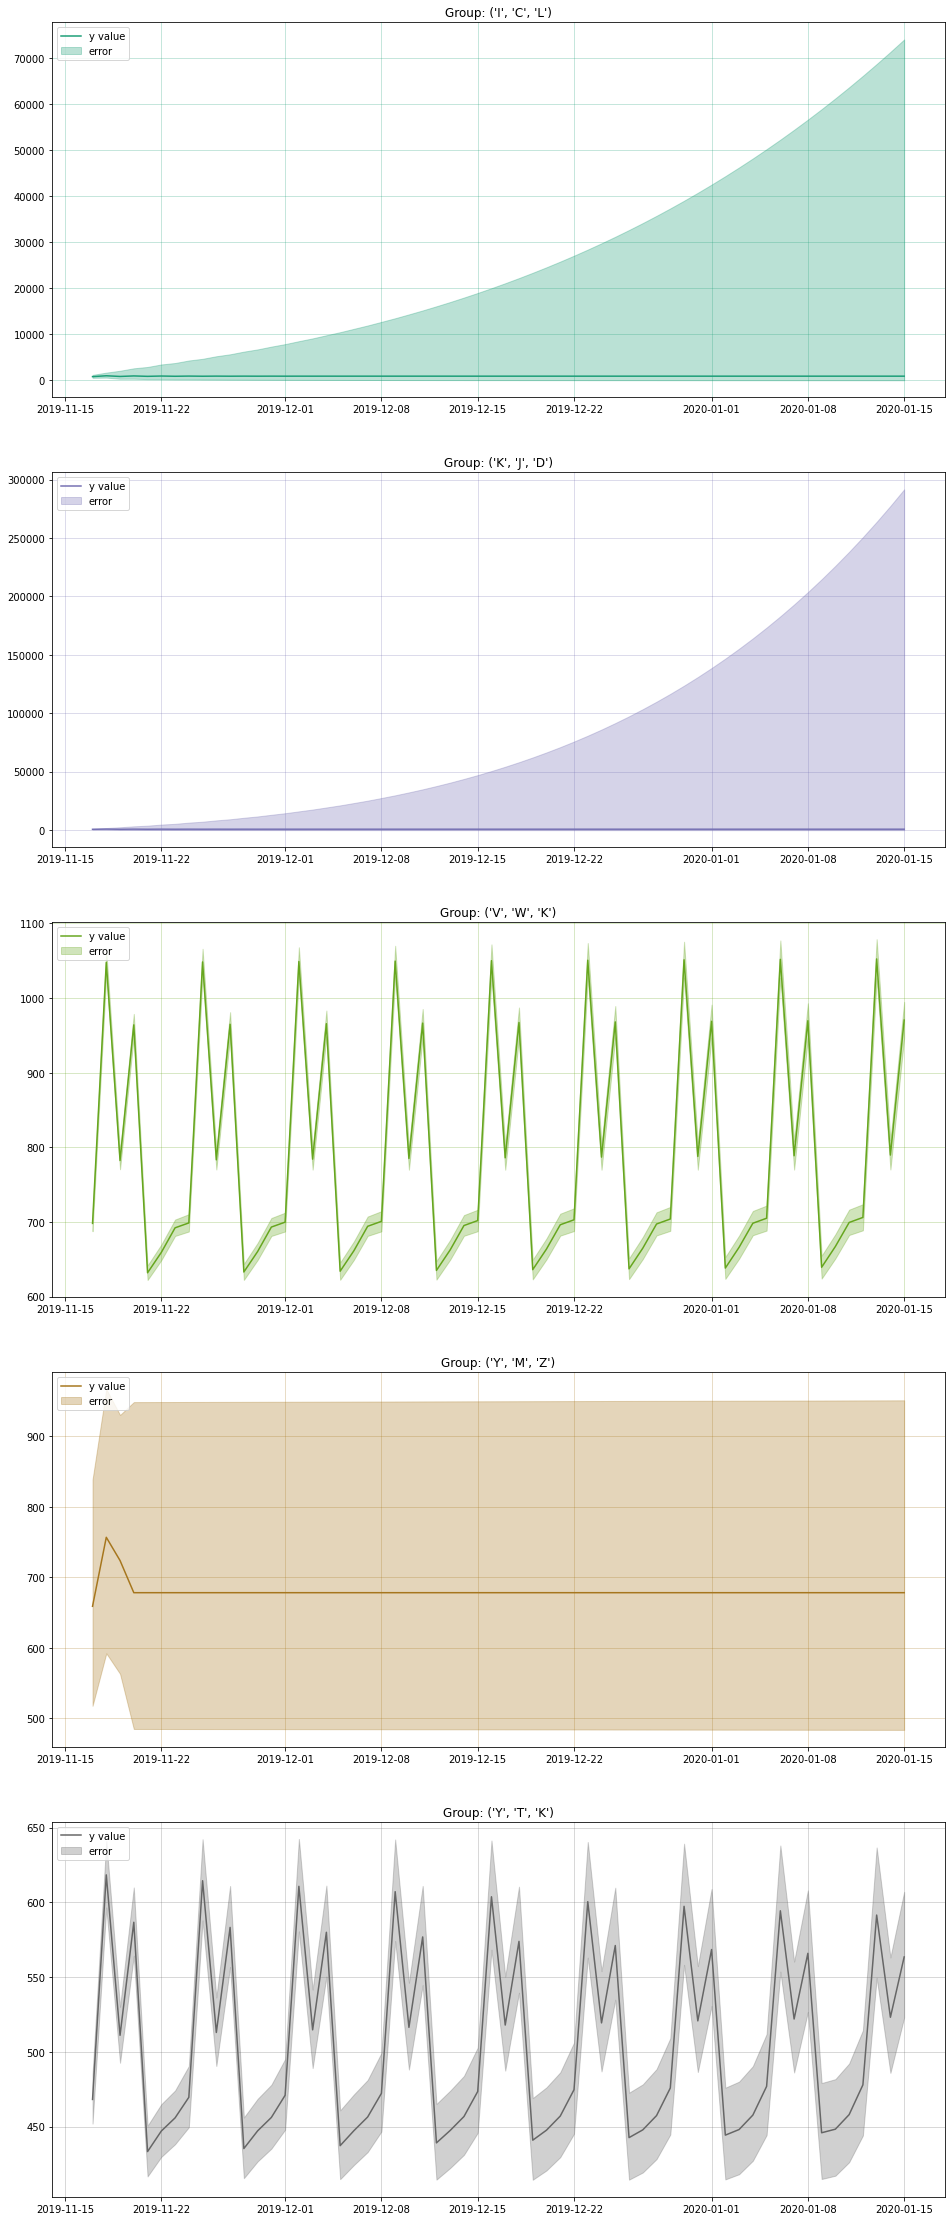

In [89]:
plot_grouped_series_forecast(pipeline_forecast, 
                             data.key_columns, 
                             "ds", 
                             "forecast", 
                             "yhat_lower", 
                             "yhat_upper"
                            )

These series are definitely not in need of log transformation to build effective ARIMA models. That being said, your data may benefit from having an endogenous transformation applied to enforce stationarity. 